# Case Study 4 - Multiple Runs

This notebook uses the ```seaborn```, which is not listed as a requirement for this library. Therefore, make sure to install it before running this notebook. To install it, use the following:

```console
> pip install seaborn
```

## 0 - Defining Basic Functionalities

In [1]:
import sys
sys.path.append('../../notebooks')

import pandas as pd
import numpy as np
import uci_dataset as database
from matplotlib.pyplot import figure

import raimitigations.dataprocessing as dp
from notebooks.download import download_datasets
import case_study_utils as cs

N_EXEC = 20

USE_AUC_TH = False

In [2]:
def get_encoders():
	education_order = ["Below Secondary", "Bachelor's", "Master's & above"]

	# Encode 'education' using ordinal encoding
	#enc_ord = dp.EncoderOrdinal(col_encode=["education"],
	#							categories={"education":education_order},
	#							verbose=False
	#						)
	enc_ord = dp.EncoderOrdinal(categories={"education":education_order},
								verbose=False
							)
	enc_ohe = dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)
	return enc_ord, enc_ohe

# -----------------------------------
def encode_case4(df):
	enc_ord, enc_ohe = get_encoders()
	enc_ord.fit(df)
	proc_df = enc_ord.transform(df)

	# Encode the remaining categorical columns using One-Hot Encoding
	#enc_ohe.fit(proc_df)
	#proc_df = enc_ohe.transform(proc_df)
	return proc_df


# -----------------------------------
def encode_case4_train_test(train_x, test_x):
	enc_ord, enc_ohe = get_encoders()
	enc_ord.fit(train_x)
	train_x_enc = enc_ord.transform(train_x)
	test_x_enc = enc_ord.transform(test_x)

	#enc_ohe.fit(train_x_enc)
	#train_x_enc = enc_ohe.transform(train_x_enc)
	#test_x_enc = enc_ohe.transform(test_x_enc)
	return train_x_enc, test_x_enc


# -----------------------------------
def impute_case4(df):
	imputer = dp.BasicImputer(	numerical={	'missing_values':np.nan,
											'strategy':'constant',
											'fill_value':-1},
								verbose=False)
	imputer.fit(df)
	proc_df = imputer.transform(df)
	return proc_df


# -----------------------------------
def impute_case4_train_test(train_x, test_x):
	imputer = dp.BasicImputer(	numerical={	'missing_values':np.nan,
											'strategy':'constant',
											'fill_value':-1},
								verbose=False)
	imputer.fit(train_x)
	train_x_enc = imputer.transform(train_x)
	test_x_enc = imputer.transform(test_x)
	return train_x_enc, test_x_enc

In [3]:
def test_base(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = encode_case4(df)
	proc_df = impute_case4(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = cs.remove_corr_feat(df, label_col)
	proc_df = encode_case4(proc_df)
	proc_df = impute_case4(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr_transf(df, label_col, n_exec, scaler_ref, model_name, num_col=None):
	result_list = []
	proc_df = cs.remove_corr_feat(df, label_col)
	proc_df = encode_case4(proc_df)
	proc_df = impute_case4(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat

# -----------------------------------
def test_smote_transf(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, under=False):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = cs.remove_corr_feat(proc_df, label_col)
	proc_df = encode_case4(proc_df)
	proc_df = impute_case4(proc_df)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = cs.artificial_smote(train_x, train_y, art_str, under)
		if feat_sel_type is not None:
			train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
		if scaler_ref is not None:
			train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat



# -----------------------------------
def test_ctgan_first(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, savefile=None):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = cs.remove_corr_feat(proc_df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = cs.artificial_ctgan(train_x, train_y, art_str, savefile, epochs=200)
		train_x, test_x = encode_case4_train_test(train_x, test_x)
		train_x, test_x = impute_case4_train_test(train_x, test_x)
		if feat_sel_type is not None:
			train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
		if scaler_ref is not None:
			train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat

## 1 - Understanding the Data

In [4]:
data_dir = '../../../datasets/'
download_datasets(data_dir)

df =  pd.read_csv(data_dir + 'hr_promotion/train.csv')
df.drop(columns=['employee_id'], inplace=True)
label_col = "is_promoted"
df

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  50684 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%         54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


In [6]:
num_col = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score']

## 2 - Efficiency of Different Classes from raimitigations.dataprocessing lib

### XGBoost Model

#### Data Transformations

In [7]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Power")

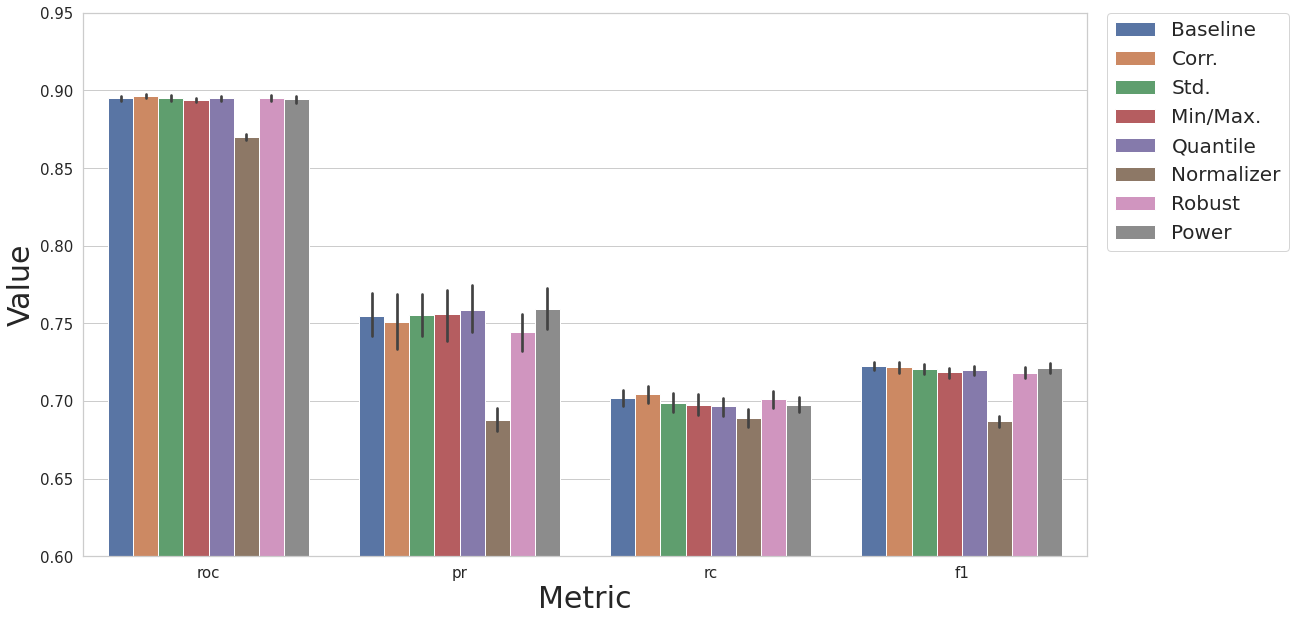

In [8]:
cs.plot_results(result_df, y_lim=[0.6, 0.95])

#### Feature Selection

In [9]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost")

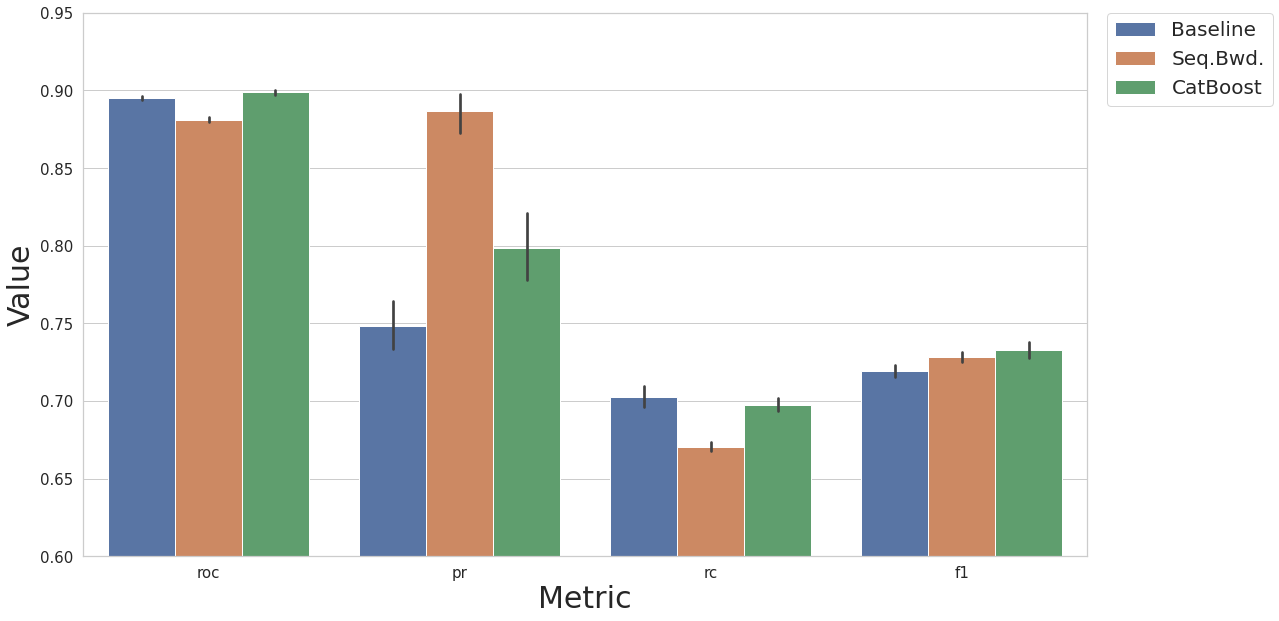

In [10]:
cs.plot_results(result_df, y_lim=[0.6, 0.95])

#### Artificial Instances - SMOTE

In [11]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.2, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, art_str=0.2, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK")

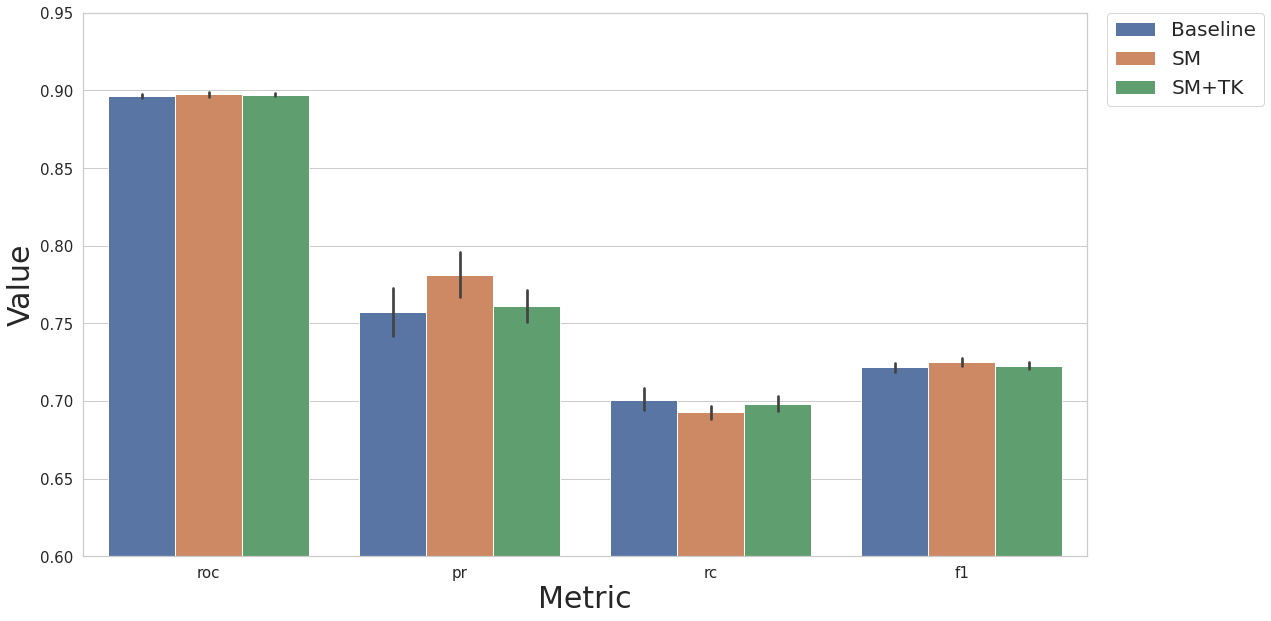

In [12]:
cs.plot_results(result_df, y_lim=[0.6, 0.95])

#### Artificial Instances - CTGAN

In [13]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, feat_sel_type=None, art_str=0.2, savefile="4_1.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.2")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, feat_sel_type=None, art_str=0.3, savefile="4_1.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.3")


/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/

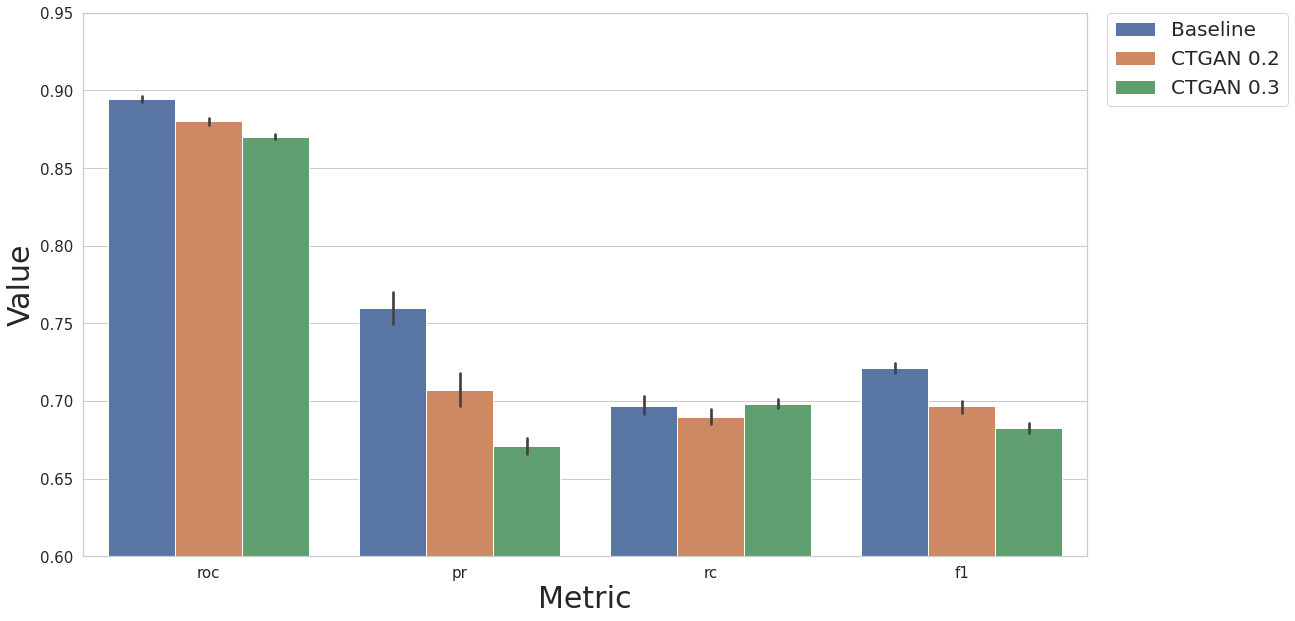

In [14]:
cs.plot_results(result_df, y_lim=[0.6, 0.95])